In [26]:
import zipfile
import dataclasses
import lzma
from types import MappingProxyType
from pathlib import Path, PurePosixPath

import msgpack
import cbor2
import numpy as np
import pandas as pd
import attrs
import yaml
import matplotlib.pyplot as plt

from arc25 import dataset, serialisation, tools

In [18]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"

In [19]:
for fn in data_root.glob("*.zip"):
    print(fn.name)

osfstorage-archive.zip
ARC-AGI-2-main.zip
ARC-AGI-master.zip
LARC-main.zip
arc-prize-2025.zip
ConceptARC-main.zip


In [20]:
def canonicalise(chal):
    return attrs.evolve(
        chal,
        train = tuple(sorted(chal.train,key=lambda iop:cbor2.dumps(serialisation.serialise(iop.input)))),
        test = tuple(sorted(chal.test,key=lambda iop:cbor2.dumps(serialisation.serialise(iop.input)))),
    )
 

In [21]:
all_challenges = {}
all_subsets = {}

In [64]:
ds_name = "concept-arc"
ds_root = data_root/"ConceptARC-main.zip"
subdsi = {}
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in sorted(zfh.filelist,key=lambda zfi:zfi.filename):
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        if not fn.parts[:2] == ("ConceptARC-main","corpus"):
            continue
        subds = fn.parts[2]
        i = subdsi.setdefault(subds,len(subdsi))
        name = fn.with_suffix("").name
        assert name.startswith(subds)
        cid = f"ca-{i:02d}-{int(name[len(subds):]):02d}"
        data = dataset.load_json(ds_root,zfi.filename)
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)

In [65]:
ds_name = "arc-agi-1"
ds_root = data_root/"ARC-AGI-master.zip"
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in zfh.filelist:
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        assert fn.parts[:2] == ("ARC-AGI-master","data")
        subds = fn.parts[2]
        cid = fn.with_suffix("").name
        data = dataset.load_json(ds_root,zfi.filename)
        assert data.pop("name",cid) == cid
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}.{subds}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)

In [66]:
ds_name = "arc-agi-2"
ds_root = data_root/"ARC-AGI-2-main.zip"
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in zfh.filelist:
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        assert fn.parts[:2] == ("ARC-AGI-2-main","data")
        subds = fn.parts[2]
        cid = fn.with_suffix("").name
        data = dataset.load_json(ds_root,zfi.filename)
        assert data.pop("name",cid) == cid
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}.{subds}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)

In [67]:
ds_name = "larc"
ds_root = data_root/"LARC-main.zip"
larc_human_info = {}
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in zfh.filelist:
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        if fn.parts[:3] != ("LARC-main","dataset","tasks_json"):
            continue
        fname = fn.with_suffix("").name
        data = dataset.load_json(ds_root,zfi.filename)
        cid = data.pop("name")
        assert cid.endswith(".json")
        cid = cid.rsplit(".",1)[0]
        descr =  data.pop("descriptions")
        if True:
            # discard grid-like stuff, and other things we don't care
            for kk in ["action_sequence","attempt_jsons","time","max_idle_time","timestamp","uid","description_time","verification_time"]:
                for vv in descr.values():
                    vv.pop(kk,None)
                    for v in vv.get("builds",{}).values():
                        v.pop(kk,None)
            larc_human_info[cid] = descr
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)
with lzma.LZMAFile(data_root/"larc-human.cbor.xz","wb") as fh:
    fh.write(cbor2.dumps(serialisation.serialise(larc_human_info)))


In [68]:
ds_root = data_root/"osfstorage-archive.zip"
with zipfile.ZipFile(ds_root,"r") as zfh:
    if False:
        for zfi in sorted(zfh.filelist,key=lambda zfi:zfi.filename):
            fn = PurePosixPath(zfi.filename)
            print(fn)
        print()
        with zfh.open("data/readme.md","r") as fh:
            print(fh.read().decode("utf-8"))
    if False:
        with zfh.open("data/data.csv","r") as fh:
            action_data = pd.read_csv(fh)
    with zfh.open("data/summary_data.csv","r") as fh:
        data = pd.read_csv(fh)

In [82]:
ds_name = "harc"

d = data.loc[:,"task_name task_type hashed_id attempt_number solved first_written_solution last_written_solution".split()]
harc_human_info = {}
for (cid,subsid),g in d.groupby(["task_name","task_type"]):
    cid,sfx = cid.split(".")
    assert sfx == "json"
    chals = all_challenges.get(cid)
    assert chals is not None
    dsn = f"{ds_name}.{subsid}"
    for dss,_ in chals.values():
        if f"arc-agi-1.{subsid}" in dss:
            dss.add(dsn)
            break
    else:
        raise KeyError(f"{dsn} doesn't appear to be from ARC-AGI-1: {[dss for dss,_ in chals.values()]}")
    all_subsets.setdefault(dsn,set()).add(cid)
    sols = []
    pinfo = {}
    for hid, gg in g.groupby("hashed_id"):
        row = gg.sort_values("attempt_number").iloc[-1]
        sols.append(row.solved)
        pinfo[hid] = dict(
            solved=bool(row.solved),
            n_attempts=int(row.attempt_number),
            initial_rule_descr=row.first_written_solution,
            final_rule_descr=row.last_written_solution,
        )
    info = harc_human_info[cid] = dict(
        n_participants = len(sols),
        success_fraction = float(sum(sols)/len(sols)),
        details = pinfo,
    )
with lzma.LZMAFile(data_root/"harc-rule-descr.cbor.xz","wb") as fh:
    fh.write(cbor2.dumps(serialisation.serialise(harc_human_info)))

info

{'n_participants': 8,
 'success_fraction': 0.25,
 'details': {'0e8d32a89e4037308f0176e4d00934a7': {'solved': False,
   'n_attempts': 3,
   'initial_rule_descr': 'to fill out the monster and fill in the dark blue squares',
   'final_rule_descr': 'I thought the rule was to fill in the monster using the black squares as a guide for his head'},
  '1bc8cf37dbf6e75fe63e1a9dc1afdce3': {'solved': False,
   'n_attempts': 3,
   'initial_rule_descr': 'really good',
   'final_rule_descr': 'good'},
  '960d3d0c2bbb3560275b683d96fb74c6': {'solved': False,
   'n_attempts': 3,
   'initial_rule_descr': 'I mirrored what was on the opposite side in the blue',
   'final_rule_descr': 'I thought I was completing the picture.'},
  'cadd12df9bd49b9d5b908816b0551da2': {'solved': False,
   'n_attempts': 3,
   'initial_rule_descr': 'Fill in the dark blue input with the predicted pattern on the output.',
   'final_rule_descr': 'Find the pattern on the input to move to the output.'},
  'd0370e728bf03f39977f883ff86d

In [83]:
print(f"Total: {len(all_challenges)}\n")
cnt = {}
for k,v in all_subsets.items():
    print(f"{k}: {len(v)}")
print()
for chals in all_challenges.values():
    cdss = set()
    for dss,chal in chals.values():
        cdss.update(dss)
    dss = frozenset(cdss)
    cnt[dss] = cnt.get(dss,0)+1
for k,v in sorted(cnt.items()):
    print(f"{" | ".join(sorted(k))}: {v}")


Total: 1307

concept-arc: 160
arc-agi-1.evaluation: 400
arc-agi-1.training: 400
arc-agi-2.evaluation: 120
arc-agi-2.training: 1000
larc: 400
harc.evaluation: 400
harc.training: 400

arc-agi-1.evaluation | harc.evaluation: 18
concept-arc: 160
arc-agi-1.evaluation | arc-agi-2.training | harc.evaluation: 376
arc-agi-2.evaluation: 114
arc-agi-1.evaluation | arc-agi-2.evaluation | harc.evaluation: 6
arc-agi-1.training | harc.training | larc: 9
arc-agi-2.training: 233
arc-agi-1.training | arc-agi-2.training | harc.training | larc: 391


In [84]:
src = """
469497ad arc-agi-2.training # or arc-agi-1.training, but not larc
6d0160f0 arc-agi-2.training # or arc-agi-1.training, but not larc
9edfc990 arc-agi-2.training # or arc-agi-1.training, but not larc
b230c067 arc-agi-2.training # or arc-agi-1.training, but not larc
dc433765 arc-agi-2.training # or arc-agi-1.training, but not larc
ac0c5833 arc-agi-1.evaluation # instead of arc-agi-2.training
"""
preferences = {}
for line in src.strip().split("\n"):
    line = line.split("#")[0].strip()
    k,v = line.split()
    assert k in all_challenges
    preferences[k] = v


In [88]:
challenges = {}
for k,v in all_challenges.items():
    pref = preferences.get(k)
    if pref is not None:
        for dss,chal in v.values():
            if pref in dss:
                break
        else:
            raise ValueError(f"{pref} not found for {k}")
    else:
        (_,chal), = v.values()
    challenges[k] = chal
subsets = {k:frozenset(v) for k,v in all_subsets.items()}
for k in ["arc-agi-1","arc-agi-2","harc"]:
    subsets[k] = frozenset(all_subsets[k+".training"] | all_subsets[k+".evaluation"])
subsets["all"] = frozenset(challenges)
ds = dataset.Dataset(
    id="combined",
    challenges = MappingProxyType(challenges),
    subsets = MappingProxyType(subsets),
)
bfn = data_root/"all-challenges.cbor.xz"
with lzma.LZMAFile(bfn,"wb") as fh:
    fh.write(cbor2.dumps(serialisation.serialise(ds)))

ds2 = await dataset.Dataset.from_binary(bfn)

# assert ds2 == ds

In [86]:
ambiguous = sorted(k for k,v in all_challenges.items() if k not in preferences and len(v)>1)
print(f"{len(ambiguous)} challenges are ambiguous:")
for a in ambiguous:
    print(f"{a}: {sorted(sorted(dss) for dss,_ in all_challenges[a].values())}")

0 challenges are ambiguous:


In [98]:
double_human = sorted(subsets["larc"] & subsets["harc"])
print(len(double_human))
double_human[41]

400


'22233c11'

{'harc.training', 'arc-agi-1.training', 'larc', 'arc-agi-2.training'}


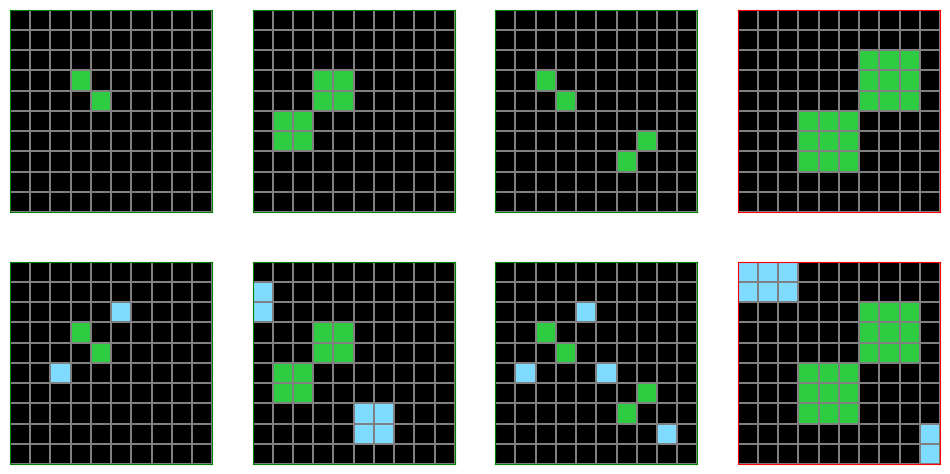

In [99]:
a = "22233c11"
for dss,chal in all_challenges[a].values():
    fig = plt.figure(figsize=(12,12))
    print(dss)
    tools.show_test_case(chal.train + chal.test,n_train=len(chal.train),orientation="h")

In [105]:
tsuc = []
for describer_id, d in larc_human_info[a].items():
    suc = []
    for builder_id, dd in d["builds"].items():
        suc.append(dd["success"])
    ssuc = d["succeeded_verification"]
    print(f"* Success {ssuc} (build rate {np.mean(suc)*100:.0f} % in {len(d["builds"])} builds):")
    for k in ["see","grid","do"]:
        print(d[f"{k}_description"])
    tsuc.append(ssuc and any(suc))
print(f"-> overall success rate: {np.mean(tsuc)*100:.0f} %\n")

hi = harc_human_info[a]
for id,d in hi["details"].items():
    print(f"* Success {d["solved"]} in {d["n_attempts"]} attempts")
    print(d["final_rule_descr"])
print(f"-> {hi["success_fraction"]*100:.0f} % out of {hi["n_participants"]}")

* Success True (build rate 33 % in 3 builds):
In the input, you should see...green pattern or patterns
The output grid size...same size
To make the output, you have to...on each of the center line direction of the green pattern, draw blue color pattern, and the blue color pattern is half of the green pattern
* Success True (build rate 0 % in 1 builds):
In the input, you should see... Set(s) of diagonal green tiles
The output grid size... remains the same size as the input grid.
To make the output, you have to... Put a light blue tile diagonal of each side of the green tiles that skips one black tile. Imagine an X is trying to be created, EXCEPT the light blue tiles skip the first diagonal tile (leave black) to make one light blue tile on each side.
* Success True (build rate nan % in 0 builds):
In the input, you should see...diagonal green line(s)
The output grid size...remains the same as the input grid
To make the output, you have to...replicate the diagonal green line(s). At a perpe

In [103]:
d

{'solved': True,
 'n_attempts': 1,
 'initial_rule_descr': 'I made blue squares on the opposite sides of the green shapes',
 'final_rule_descr': 'I made blue squares on the opposite sides of the green shapes'}

In [15]:
def treediff(a, b, *,path=()):
    ps = ".".join(path)
    ta = type(a)
    tb = type(b)
    if ta != tb:
        print(f"{ps}: type mismatch: {ta.__qualname__} != {tb.__qualname__}")
        return
    match a:
        case dict() | MappingProxyType():
            for k in set(a) | set(b):
                treediff(a.get(k), b.get(k), path=path+(k,))
        case list() | tuple():
            if len(a) != len(b):
                print(f"{ps}: length mismatch: {len(a)} != {len(b)}")
            else:
                for i,(av,bv) in enumerate(zip(a,b)):
                    treediff(av,bv,path=path+(str(i),))
        case np.ndarray():
            if a.shape != b.shape:
                print(f"{ps}: shape mismatch: {a.shape} != {b.shape}")
            elif np.any(a != b):
                print(f"{ps}: data mismatch: {np.sum(a != b)} / {a.size}")
        case _ if dataclasses.is_dataclass(ta):
            for f in dataclasses.fields(ta):
                k = f.name
                treediff(getattr(a,k),getattr(b,k),path=path+(k,))
        case _ if attrs.has(ta):
            for f in attrs.fields(ta):
                k = f.name
                treediff(getattr(a,k),getattr(b,k),path=path+(k,))
        case _:
            if a != b:
                print(f"{ps}: mismatch: {str(a)[:80]} != {str(b)[:80]}")
                
    
d = list(all_challenges[a].values())
treediff(d[0][1],d[1][1])


train.0.input.image._data: data mismatch: 2 / 625


In [16]:
treediff(ds,ds2)